In [33]:
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, hstack, vstack, join, MaskedColumn
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as au
from glob import glob
from spectral_cube import SpectralCube
import scipy 
from reproject import reproject_interp
from scipy.optimize import curve_fit

from tqdm.auto import tqdm 
from astropy.io import fits
import matplotlib as mpl
import pyregion
import aplpy
import math
import os
import pickle

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

In [2]:
"""Easy pickel"""

def save_pickle(a, filename): 
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('[INFO] Saved to %s' %filename)
    return()

def load_pickle(filename):
    with open('%s'%filename, 'rb') as handle:
        b = pickle.load(handle)
    print('[INFO] Load %s' %filename)
    return(b)

In [3]:
def find_nearest(array, value):
    """find nearest value in array, and return id"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [4]:
"""Load properties of the hst nebula catalouge"""
props_all = Table.read('../../analysis/dendro/props_all/props_all_2.fits')
n = len(props_all)

In [5]:
def get_SB99models(inputdir='/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/sb99/fiducial/fiducial_6p0linear/', tmin = 0, tmax = 1e8):
    
    """Get SB99 models"""

    t_ewidth = Table.read('%s/fiducial_6p0linear.ewidth1' %(inputdir), format='ascii', header_start=3, data_start=4)
    names = ['TIME', 'QHI', 'QHIf', 'QHeI', 'QHeIf', 'QHeII', 'QHeIIf', 'logL']
    t_quanta = Table.read('%s/fiducial_6p0linear.quanta1' %(inputdir), format='ascii', data_start=5, names=names)
    names = ['TIME', 'ALLp', 'OBp', 'RSGp', 'LBVp', 'WRp', 'ALLe', 'ALLm', 'OBm', 'RSGm', 'LBVm', 'WRm']
    t_power = Table.read('%s/fiducial_6p0linear.power1' %(inputdir), format='ascii', data_start=5, names=names)
    names = ['TIME', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Mdotwind', 'Mdotsne','Mdotboth', 'Mtot']
    t_yield = Table.read('%s/fiducial_6p0linear.yield1' %(inputdir), format='ascii', data_start=5, names=names)

    time = t_ewidth['TIME']
    mask = ((time>=tmin) & (time<=tmax))
    time = time[mask]*au.yr

    Q = t_quanta['QHI'][mask]
    Mdot = t_yield['Mdotwind'][mask]
    Lmech = t_power['ALLp'][mask]
    Lbol = t_quanta['logL'][mask]
    LHa = t_ewidth['LUM(H_A)'][mask]
    Lfrac = 10**(t_quanta['logL'][mask]-t_ewidth['LUM(H_A)'][mask])
    
    return({'time':time, 'mdot':Mdot, 'lmech':Lmech, 'lbol':Lbol, 'lha':LHa, 'lfrac':Lfrac})

SB99models = get_SB99models()

In [6]:
def get_SB99models_arr(inputdir_='/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/sb99/fiducial/'):

    masses = ['4p0', '4p5', '5p0', '5p5', '6p0', '6p5']
    masses_ = [1e4, 5e4, 1e5, 5e5, 1e6, 5e6]
    n = len(masses)

    t_ewidth = dict.fromkeys(masses)
    t_quanta = dict.fromkeys(masses)
    t_power = dict.fromkeys(masses)
    t_yield = dict.fromkeys(masses)

    for mass, mass_,i in zip(masses, masses_, range(n)):


        inputdir = '%s/fiducial_%s' %(inputdir_, mass) 

        t_ewidth_ = Table.read('%s/fiducial_%s.ewidth1' %(inputdir, mass), format='ascii', header_start=3, data_start=4)

        names = ['TIME', 'QHI', 'QHIf', 'QHeI', 'QHeIf', 'QHeII', 'QHeIIf', 'logL']
        t_quanta_ = Table.read('%s/fiducial_%s.quanta1' %(inputdir, mass), format='ascii', data_start=5, names=names)

        names = ['TIME', 'ALLp', 'OBp', 'RSGp', 'LBVp', 'WRp', 'ALLe', 'ALLm', 'OBm', 'RSGm', 'LBVm', 'WRm']
        t_power_ = Table.read('%s/fiducial_%s.power1' %(inputdir, mass), format='ascii', data_start=5, names=names)

        names = ['TIME', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Mdotwind', 'Mdotsne','Mdotboth', 'Mtot']
        t_yield_ = Table.read('%s/fiducial_%s.yield1' %(inputdir, mass), format='ascii', data_start=5, names=names)

        t_ewidth_['TIME'] = np.log10(t_ewidth_['TIME'])
        t_quanta_['TIME'] = np.log10(t_quanta_['TIME'])
        t_power_['TIME'] = np.log10(t_power_['TIME'])
        t_yield_['TIME'] = np.log10(t_yield_['TIME'])

        t_ewidth_['MASS'] = np.array([mass_]*len(t_power_['TIME']))
        t_quanta_['MASS'] = np.array([mass_]*len(t_power_['TIME']))
        t_power_['MASS'] = np.array([mass_]*len(t_power_['TIME']))
        t_yield_['MASS'] = np.array([mass_]*len(t_power_['TIME']))

        if i == 0: 
            mass_arr = t_ewidth_['MASS']
            time_arr = t_ewidth_['TIME']
            mdot_arr = t_yield_['Mdotwind']
            lmec_arr = t_power_['ALLp']
        else: 
            mass_arr = np.vstack([mass_arr,t_ewidth_['MASS']])
            time_arr = np.vstack([time_arr,t_ewidth_['TIME']])
            mdot_arr = np.vstack([mdot_arr,t_yield_['Mdotwind']]) 
            lmec_arr = np.vstack([lmec_arr,t_power_['ALLp']]) 

    mass_arr = np.log10(mass_arr)
    
    return({'mass':mass_arr, 'time':time_arr, 'mdot':mdot_arr, 'lmec':lmec_arr})

SB99models_arr = get_SB99models_arr()

In [7]:
#### Defines

age = props_all['reg_dolflux_Age_MinChiSq'].quantity.to('yr')
mass = props_all['reg_dolflux_Mass_MinChiSq'].quantity.to('Msun')
lha = props_all['ha_lum']
te = props_all['T_N2_REFIT']*au.K
te[np.isnan(te)] = 8000*au.K
ne = props_all['ne']
radius = props_all['mean_sigma_pc']

lfrac = np.empty(n) *np.nan

  0%|          | 0/184 [00:00<?, ?it/s]

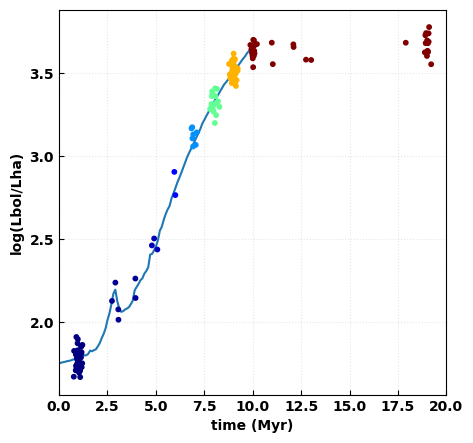

In [8]:
# Get Lfrac 

for regionID in tqdm(range(n)):
    
    _, mask = find_nearest(SB99models['time'].value, age[regionID].value)
    lfrac[regionID] = SB99models['lfrac'][mask]
    
props_all['lbol/lha'] = lfrac *au.dimensionless_unscaled
####

#### -- plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

ax.plot(SB99models['time'].to('Myr'), np.log10(SB99models['lfrac']))

ax.scatter(age.to('Myr')+np.random.normal(size=len(age))*au.Myr*0.1, 
           np.log10(lfrac)+np.random.normal(size=len(age))*0.05, 
           c=lfrac, zorder=10, cmap='jet', s=10)

ax.set_xlim([0,20])

ax.set_xlabel('time (Myr)')
ax.set_ylabel('log(Lbol/Lha)')

ax.grid(alpha=0.3, linestyle=':')

In [9]:
# Get Lbol 

def get_lbol(lha, conv=17.684):
    """Convert Lhalpha luminoisty to Lbolometric luminosity
        conv = 138: Taken from Kennicutt & Evans (2012) - Lopez et al. (2014)
        conv = 17.684"""
    lbol=conv*lha
    return lbol

lbol = get_lbol(lha.quantity, conv=props_all['lbol/lha'].quantity.value)
lbol_const = get_lbol(lha.quantity, conv=88.2) #with constant conversion from Barnes21

In [10]:
### Get PDIR

def get_pdir(lbol, radius):
    """Convert bolometric luminoisty to direct radiation pressure
        Taken from Lopez et al. (2014)"""
    pdir = (3 * lbol.to('Lsun')) / (4*np.pi * (radius.to('cm')**2) * ac.c.to('cm/s') ) / ac.k_B
    return pdir.to('K/cm^3')

pdir = get_pdir(lbol, radius)
pdir_const = get_pdir(lbol_const, radius)

props_all['pdir'] = np.log10(pdir.value) * pdir.unit
props_all['pdir_const'] = np.log10(pdir_const.value) * pdir.unit

props_all['lbol'] = lbol
props_all['lbol_const'] = lbol_const

In [11]:
# Get Lmech, Mdot, vwind

def func(x, a, b):
    return (a*x)+b

xdata = np.unique(SB99models_arr['mass'])
ydata = np.log10(np.nanmean((10**SB99models_arr['mdot'])/(10**SB99models_arr['mdot'][0]),axis=1))

popt_mdot, _ = curve_fit(func, xdata, ydata)

# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(1,2,1)
# ax.scatter(xdata,ydata)
# ax.plot(xdata, func(xdata, *popt_mdot), 'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt_mdot))
# ax.grid(alpha=0.3, linestyle=':')
# ax.legend(fontsize=9)
# ax.set_xlabel('Mass log(Msun)')
# ax.set_ylabel('Mass loss rate (normalised to Mclust=1e4sun)')
# plt.show()

xdata = np.unique(SB99models_arr['mass'])
ydata = np.log10(np.nanmean((10**SB99models_arr['lmec'])/(10**SB99models_arr['lmec'][0]),axis=1)) #fraction in logspace

popt_lmec, _ = curve_fit(func, xdata, ydata)

# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(1,2,1)
# ax.scatter(xdata,ydata)
# ax.plot(xdata, func(xdata, *popt_lmec), 'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt_lmec))
# ax.grid(alpha=0.3, linestyle=':')
# ax.legend(fontsize=9)
# ax.set_xlabel('Mass log(Msun)')
# ax.set_ylabel('Mech. lum (normalised to Mclust=1e4sun)')
# plt.show()


lmec = np.empty(len(props_all['_idx']))*np.nan
mdot = np.empty(len(props_all['_idx']))*np.nan

for regionID in tqdm(range(n)):

    #Get in correct units
    clust_mass_ = np.log10(mass.value[regionID]) 
    clust_age_ = np.log10(age.to('yr').value[regionID])

    # Values for a 10^4Msun cluster, of the age of the obs cluster 
    _, id_ = find_nearest(SB99models_arr['time'][0,:], clust_age_)
    lmec_ = SB99models_arr['lmec'][0,id_]
    mdot_ = SB99models_arr['mdot'][0,id_]

    # Values of offset from a 10^4Msun cluster, due to more or less mass of obs cluster 
    cf_lmec = func(clust_mass_, *popt_lmec)
    cf_mdot = func(clust_mass_, *popt_mdot)

    # Values of 10^4Msun cluster +- offset due to obs mass
    lmec[regionID] = lmec_+cf_lmec
    mdot[regionID] = mdot_+cf_mdot
    
lmec = (10**lmec) *au.erg/au.s
mdot = ((10**mdot) *au.Msun/au.yr).to('g/s')

windvelo = np.sqrt((2.0*lmec)/mdot)
windvelo = windvelo.to('km/s')

  0%|          | 0/184 [00:00<?, ?it/s]

In [12]:
### Get PDIR

def get_Pwind(mdot, windvelo, radius):
    pwind = (mdot * windvelo) / ((4./3.)*np.pi * (radius.to('cm')**2))
    pwind = (pwind/ac.k_B.cgs)
    return(pwind.to('K/cm^3'))

pwind = get_Pwind(mdot, windvelo, radius)
props_all['pwind'] = np.log10(pwind.value) * pwind.unit

In [15]:
# Get electron density from radius

def func_reccoeff(temp):
    """Get recomination recoefficent"""
    alpha = 2.753e-14 * (315614 /  temp)**1.500 / ((1.0 + (115188 / temp)**0.407)**2.242)
    return(np.array(alpha) *au.cm**3/au.s)

def get_ne(ha_lum, radius, temp):

    volume = (4./3.)*np.pi*radius.quantity**3 #in units of cm^3
    ha_lum = ha_lum.to('erg/s')
    volume = volume.to('cm^3')
    
    #Recombination rate
    ha_photon_energy = 3.02e-12   # Energy in erg of single H-alpha photon
    ha_rate = ha_lum / ha_photon_energy   # Emission rate (in photons per s) of H-alpha
    rec_rate = ha_rate / 0.45     # Per Calzetti (2012), ~45% of recombinations result in emission of an H-alpha photon

    # rec_coeff = 2.6e-13    # Recombination rate coefficient: assumes case B, T_e = 1e4 K
    rec_coeff = func_reccoeff(temp.value)

    ne = np.sqrt(rec_rate/(rec_coeff*volume))
    ne = np.array(ne)/au.cm**3
    
    return(ne)

ne_radlim = get_ne(lha, radius, te)

In [36]:
### Get PTHERM

def get_pth(ne, te, ionisation=2):
    """ionisation=2 assumes single ionised He"""
    pth = ne*te*ionisation
    return(pth.to('K/cm^3'))

pth = get_pth(ne.quantity, te)
pth_radlim = get_pth(ne_radlim, te)

props_all['ne_radlim'] = ne
props_all['pth'] = np.log10(pth.value) * pth.unit
props_all['pth_radlim'] = np.log10(pth_radlim.value) * pth.unit

# mask column 
props_all['pth'] = MaskedColumn(props_all['pth'], mask=np.isnan(props_all['pth']))

In [38]:
save_pickle(props_all, '../../analysis/dendro/props_all/props_all_3.pickel') 
props_all.write('../../analysis/dendro/props_all/props_all_3.fits', overwrite=True)

[INFO] Saved to ../../analysis/dendro/props_all/props_all_3.pickel
